In [88]:
from importlib import reload
from pyfvtool import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root
from tqdm import tqdm
from scipy.interpolate import interp1d
import pandas as pd
from CoolProp.CoolProp import PropsSI

import sys
sys.path.append('..')
from pymadreq import *
import pymadreq.coreflood as cf
import pymadreq.fractional_flow as ff
import pymadreq.IO as IO

reload(ff)
reload(cf)
reload(IO)

<module 'pymadreq.IO' from 'c:\\Users\\aaeft\\Documents\\GitHub\\PyMADREQ\\examples\\..\\pymadreq\\IO.py'>

## Reading input file and defining the domain

In [89]:
# read the input file
data = IO.read_json("../examples/sample.json")
rel_perm_ww, rel_perm_ow, pc_ww, pc_ow = IO.read_transport_functions(data)
core_plug = IO.read_core_properties(data)
fluids = IO.read_fluids(data)
IC = IO.read_initial_conditions(data) # initial conditions
BC = IO.createFloodingCondition(data["BC"]) # boundary conditions
numerical_params = IO.read_numerical_settings(data)
m = IO.read_flooding_domain(data)

## Read the Excel file of the experimental data

In [90]:
# TODO: add excel reader for updating the model input for optimization
# df = pd.read_excel("E-31-1-flooding-formatted.xlsx")
xls = pd.ExcelFile("E-31-imbibitions-formatted.xlsx")
sheet_names = xls.sheet_names
print(sheet_names)

['core', 'brine', 'oil', 'condition', 'DSW', 'SW', 'FW']


In [91]:
df_core = pd.read_excel("E-31-imbibitions-formatted.xlsx", sheet_name="core")
df_oil = pd.read_excel("E-31-imbibitions-formatted.xlsx", sheet_name="oil")
df_cond = pd.read_excel("E-31-imbibitions-formatted.xlsx", sheet_name="condition")
df_imb = pd.read_excel("E-31-imbibitions-formatted.xlsx", sheet_name="SW")

In [92]:
core_dics = df_core.set_index('parameter')['value'].to_dict()
oil_dict = df_oil.set_index('property')['value'].to_dict()
cond_dict = df_cond.set_index('parameter')['value'].to_dict()

In [93]:
BC.production_pressure = cond_dict['back_pressure']*1e5 # Pa
T = cond_dict['temperature'] + 273.15 # K

core_plug.core_length = core_dics['L']/100 # m
core_plug.core_diameter = core_dics['D']/100 # m
core_plug.porosity = core_dics['porosity']
core_plug.permeability = core_dics['perm_water']*1e-15 # m2
core_plug.pore_volume = core_dics['pore_volume']/1e6 # m3
core_plug.cross_sectional_area = core_plug.core_diameter**2*np.pi/4 # m2

fluids.oil_density = oil_dict['density'] # kg/m3
fluids.oil_viscosity = oil_dict['viscosity'] # Pa.s
fluids.water_density = PropsSI('D', 'T', T, 'P', BC.production_pressure, 'water') # kg/m3
fluids.water_viscosity = PropsSI('V', 'T', T, 'P', BC.production_pressure, 'water') # Pa.s

IC.sw = 1 - core_dics['Soi']
IC.p = BC.production_pressure
IC.T = T

In [94]:
t_imb = 3600*df_imb['Time (hr)'].to_numpy() # hr to s
RF_imb = df_imb['RF (%)'].to_numpy()/100 # % to fraction

In [95]:

numerical_params.simulation_time = t_imb[-1]*1.1
# assign fitted relperm parameters
rel_perm_ww.krw0 = 0.1763082
rel_perm_ww.no = 2.68964890
rel_perm_ww.nw = 1.93153404
rel_perm_ww.sor = 0.2 # 0.37729816
rel_perm_ww.swc = 0.1971
rel_perm_ww.kro0 = 0.83903614

# kro0:  0.83903614 (init = 0.5)
# krw0:  0.1763082 (fixed)
# no:    2.68964890 (init = 2)
# nw:    1.93153404 (init = 2)
# swc:   0.1971 (fixed)
# sor:   0.37729816 (init = 0.3)

In [96]:
cf2d_imb = cf.CoreImbibition(rel_perm_ww, pc_ww, core_plug, 
                             fluids, IC, BC, numerical_params, Nx=15, Nr = 5)

c:\Users\aaeft\venvs\myfvm\Lib\site-packages\pyfvtool\cell.py:97: RuntimeWarning: invalid value encountered in divide
  return CellVariable(self.domain, self.value/other.value)


## Fittin model to core flooding data

In [114]:
# using lmfit to fit a two-phase model to a dataset
from lmfit import Parameters, Model
# def residual(params, t, R):
#     cf_1d.rel_perm.kro0 = params['kro0']
#     cf_1d.rel_perm.krw0 = params['krw0']
#     cf_1d.rel_perm.nw = params['nw']
#     cf_1d.rel_perm.no = params['no']
#     t_num, R_num, dp_num = cf_1d.simulate_no_pc()
#     R_calc = interp1d(t_num, R_num)(t)
#     return (R_calc - R)

def my_model(t, sw_pc0, pc_lm, pc_hm, pc_min, pc_max):
    pc_ww = cf.CapillaryPressurePiecewise(
        sw_pc0=sw_pc0,
        pce=1e5,
        sorting_factor=2.0,
        pc_min=pc_min,
        pc_max=pc_max,
        pc_lm=pc_lm,
        pc_hm=pc_hm,
        swc=rel_perm_ww.swc,
        sor=rel_perm_ww.sor,
        extrap_factor=200.0,
        curve_factor_l=5.0,
        curve_factor_h=10.0)
    cf2d_imb = cf.CoreImbibition(rel_perm_ww, pc_ww, core_plug, 
                             fluids, IC, BC, numerical_params, Nx=20, Nr = 5)
    t_num, R_num = cf2d_imb.simulate()
    R_calc = interp1d(t_num, R_num, fill_value='extrapolate')(t)
    # dp_calc = interp1d(t_num, dp_num, fill_value='extrapolate')(t)
    return R_calc

model = Model(my_model)

params = Parameters()
params.add('sw_pc0', value=0.6, min=0.3, max=0.6)
params.add('pc_lm', value=-1e4, min=-5e4, max=-5e3, vary=True)
params.add('pc_hm', value=2e4, min=5e3, max=7e4)
params.add('pc_min', value=-1e5, min=-1e6, max=-6e4, vary=False)
params.add('pc_max', value=1e5, min=8e4, max=9e5, vary=False)

W_R = np.ones_like(t_imb)
# W_R[-2:] = 5.0
result = model.fit(RF_imb, params, t=t_imb, verbose=2, 
                   weights=W_R, method='leastsq')
# result2 = model2.fit(R_data, params, t=t_data, verbose=True, 
#                      weights=W_R, method='nelder')
# out = minimize(residual, params, args=(t_data, R_data))

KeyboardInterrupt: 

In [ ]:
print(result.fit_report())
print("Optimized Parameters:")
print(result.params)

[[Model]]
    Model(my_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 47
    # variables        = 3
    chi-square         = 1.51415709
    reduced chi-square = 0.03441266
    Akaike info crit   = -155.458569
    Bayesian info crit = -149.908126
    R-squared          = -0.54694912
[[Variables]]
    sw_pc0:  0.59999999 +/- 8.8242e-08 (0.00%) (init = 0.6)
    pc_lm:  -9999.01769 +/- 9.99241321 (0.10%) (init = -10000)
    pc_hm:   19976.3361 +/- 13.0477066 (0.07%) (init = 20000)
    pc_min: -100000 (fixed)
    pc_max:  100000 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(pc_lm, pc_hm)  = -0.8939
    C(sw_pc0, pc_lm) = -0.1756
Optimized Parameters:
Parameters([('sw_pc0', <Parameter 'sw_pc0', value=0.599999988004289 +/- 8.82e-08, bounds=[0.3:0.6]>), ('pc_lm', <Parameter 'pc_lm', value=-9999.01768639755 +/- 9.99, bounds=[-50000.0:-5000.0]>), ('pc_hm', <Parameter 'pc_hm', value=19976.33607894976 +/- 13, b

In [ ]:
R_fit= result.eval()


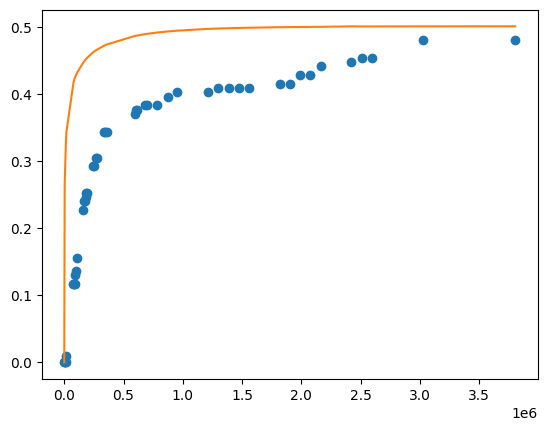

In [ ]:
plt.semilogx(t_imb, RF_imb, 'o')
plt.semilogx(t_imb, R_fit, '-')

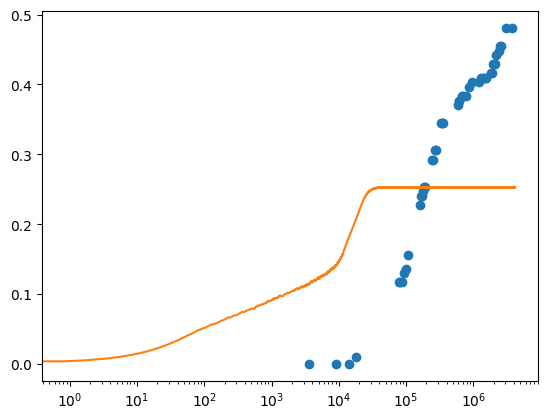

In [113]:
# R_calc = my_model(t_imb, 0.55, -1e4, 2e4, -1e5, 5e5)
rel_perm_ww.krw0 = 0.1763082
rel_perm_ww.no = 2.0 #2.68964890
rel_perm_ww.nw = 2.0 # 1.93153404
rel_perm_ww.sor = 0.37729816
rel_perm_ww.swc = 0.1971
rel_perm_ww.kro0 = 0.83903614

pc_ww = cf.CapillaryPressurePiecewise(
        sw_pc0=0.4,
        pce=1e5,
        sorting_factor=2.0,
        pc_min=-1e5,
        pc_max=5e5,
        pc_lm=-1e4,
        pc_hm=2e4,
        swc=rel_perm_ww.swc,
        sor=rel_perm_ww.sor,
        extrap_factor=200.0,
        curve_factor_l=5.0,
        curve_factor_h=10.0)
# cf2d_imb.pc = pc_ww
cf2d_imb = cf.CoreImbibition(rel_perm_ww, pc_ww, core_plug, 
                             fluids, IC, BC, numerical_params, Nx=15, Nr = 5)
t_calc, R_calc = cf2d_imb.simulate()
plt.semilogx(t_imb, RF_imb, 'o')
plt.semilogx(t_calc, R_calc, '-')

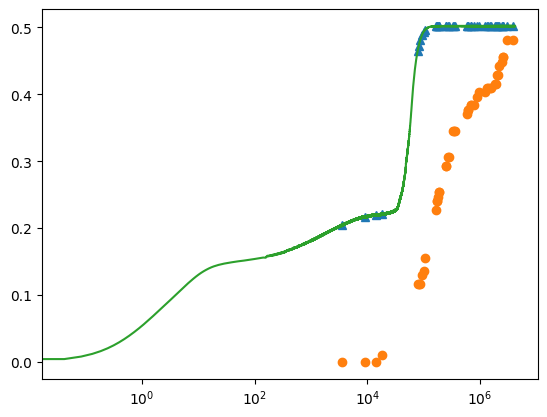

In [106]:
plt.semilogx(t_imb, interp1d(t_calc, R_calc)(t_imb), '^')
plt.semilogx(t_imb, RF_imb, 'o')
plt.semilogx(t_calc, R_calc, '-')